### Reference Links

https://docs.smith.langchain.com/reference/data_formats/run_data_format
https://docs.smith.langchain.com/reference/data_formats/trace_query_syntax
https://docs.smith.langchain.com/observability/how_to_guides/export_traces

# Setup

In [1]:
#Setup tracing & key
from google.colab import userdata
import os
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get('Smith2')

from langsmith import Client

client = Client()

In [2]:
project_runs = client.list_runs(project_name="default")
print(project_runs)

<generator object Client.list_runs at 0x7f328c943880>


In [3]:
count = sum(1 for _ in project_runs)
print(f"The number of entries in project_runs is: {count}")

The number of entries in x_llm_runs is: 603


# Method
How to **query & export runs list** into pandas

---
*Run 4 : Success !*

In [8]:
# @title query & export runs list into pandas
from collections import defaultdict
from concurrent.futures import Future, ThreadPoolExecutor
from datetime import datetime, timedelta

from langsmith import Client
from tqdm.auto import tqdm

client = Client()
#Change as needed
project_name = "default"
num_days = 3

# List all runs
all_runs = client.list_runs(
  project_name=project_name,
  start_time=datetime.now() - timedelta(days=num_days),
  # We don't need to fetch inputs, outputs, and other values that # may increase the query time
  select=["id", "name", "run_type"],
)

data = []
futures: list[Future] = []
trace_cursor = 0
trace_batch_size = 50

all_runs_by_parent = defaultdict(lambda: defaultdict(set))
# Do not exceed rate limit
with ThreadPoolExecutor(max_workers=2) as executor:
  # Group all runs by parent run ID
  for run in tqdm(all_runs):
      # Collect all tools invoked within a given trace
      all_runs_by_parent[run.id]["tools_involved"].add(run.name)

      # Only if needed; maybe send a batch of parent run IDs to the server
      # this lets us query for the root runs in batches
      # while still processing the all runs
      #if len(all_runs_by_parent) % trace_batch_size == 0:
          #if this_batch := list(all_runs_by_parent.keys())[
              #trace_cursor : trace_cursor + trace_batch_size
          #]:
              #trace_cursor += trace_batch_size
              #futures.append(
                  #executor.submit(
                      #client.list_runs,
                      #project_name=project_name,
                      #run_ids=this_batch,
                      #select=["name", "total_cost", "status", "start_time", "total_tokens", "prompt_cost", "completion_cost", "parent_run_id"],
                  #)
              #)

  if this_batch := list(all_runs_by_parent.keys())[trace_cursor:]:
      futures.append(
          executor.submit(
              client.list_runs,
              project_name=project_name,
              run_ids=this_batch,
              select=["name","inputs","outputs","total_cost", "status", "start_time", "total_tokens", "prompt_cost", "completion_cost", "parent_run_id"],
          )
      )


for future in tqdm(futures):
  root_runs = future.result()
  for root_run in root_runs:
      root_data = all_runs_by_parent[root_run.id]
      data.append(
          {
              "run_id": root_run.id,
              "run_name": root_run.name,
              "run_type": root_run.run_type,
              "input": root_run.inputs,
              "output": root_run.outputs,
              "total_cost (USD)": root_run.total_cost,
              "status": root_run.status,
              "start_time": root_run.start_time,
              "total_tokens": root_run.total_tokens,
              "prompt_cost": root_run.prompt_cost,
              "completion_cost": root_run.completion_cost,
              "parent_run_id": root_run.parent_run_id,
              "tools_involved": list(root_data["tools_involved"]),
          }
      )

# (Optional): Convert to a pandas DataFrame

import pandas as pd

df3 = pd.DataFrame(data)
df3.head()

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

,run_id,run_name,run_type,input,output,total_cost (USD),status,start_time,total_tokens,prompt_cost,completion_cost,parent_run_id,tools_involved
0,3313c775-2679-4a44-8efe-7070d6a8ff69,JsonOutputKeyToolsParser,parser,"{'input': {'content': '', 'additional_kwargs':...","{'text_answer': 'I am sorry, I cannot fulfill ...",None,success,2025-07-20 15:32:27.255047,0,None,None,28a0a6b3-867e-4b65-8eb6-a9c594978e88,[JsonOutputKeyToolsParser]
1,5a31a5e4-6839-459d-88a9-2d52ff6b33a7,ChatGoogleGenerativeAI,llm,"{'messages': [[{'lc': 1, 'type': 'constructor'...","{'generations': [[{'text': '', 'generation_inf...",0.0000526,success,2025-07-20 15:32:26.474695,400,0.0000358,0.0000168,28a0a6b3-867e-4b65-8eb6-a9c594978e88,[ChatGoogleGenerativeAI]
2,28a0a6b3-867e-4b65-8eb6-a9c594978e88,RunnableSequence,chain,{'input': [{'content': 'Get the daily aggregat...,"{'text_answer': 'I am sorry, I cannot fulfill ...",0.0000526,success,2025-07-20 15:32:26.473586,400,0.0000358,0.0000168,738f9af3-a7cf-4bc1-8d8f-eef239ec0341,[RunnableSequence]
3,738f9af3-a7cf-4bc1-8d8f-eef239ec0341,generate_structured_response,chain,{'messages': [{'content': 'Get the daily aggre...,{'structured_response': {'text_answer': 'I am ...,0.0000526,success,2025-07-20 15:32:26.468874,400,0.0000358,0.0000168,deba98c4-5973-4f83-8997-b3b866161dfa,[generate_structured_response]
4,deba98c4-5973-4f83-8997-b3b866161dfa,generate_structured_response,chain,{'messages': [{'content': 'Get the daily aggre...,{'structured_response': {'text_answer': 'I am ...,0.0000526,success,2025-07-20 15:32:26.468149,400,0.0000358,0.0000168,8ef57672-0a09-45dd-9280-e71e65a4cda4,[generate_structured_response]


In [9]:
#rows count
print(f"The total number of rows in the DataFrame is: {df3.shape[0]}")

The total number of rows in the DataFrame is: 603


##### Analyse : run_type


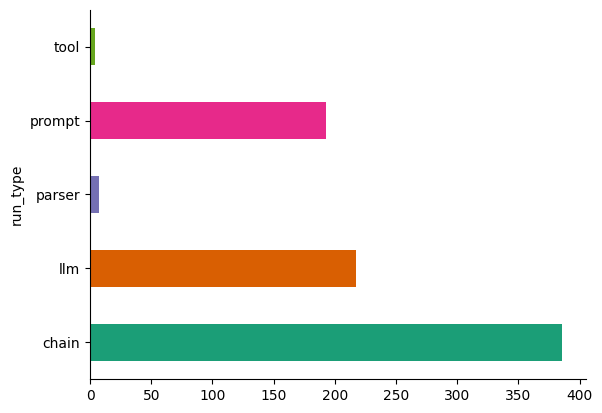

In [ ]:

from matplotlib import pyplot as plt
import seaborn as sns
df3.groupby('run_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

---

# Download Data into g sheets

In [13]:
# DIRECTLY : Save the DataFrame to a CSV file
df3.to_csv('langsmith_runs_data.csv', index=False)
print("DataFrame saved to langsmith_runs_data.csv")

DataFrame saved to langsmith_runs_data.csv


In [12]:
# INTERACTIVE : save
from google.colab import sheets
import uuid
import json

# Convert UUID objects to strings in the DataFrame
for col in df3.columns:
    if df3[col].apply(lambda x: isinstance(x, uuid.UUID)).any():
        df3[col] = df3[col].astype(str)

# Convert complex types to strings and truncate to avoid cell size limit
for col in ['input', 'output']:
    if col in df3.columns:
        df3[col] = df3[col].apply(lambda x: json.dumps(x) if isinstance(x, (dict, list)) else str(x))
        df3[col] = df3[col].str[:49000] # Truncate to avoid exceeding the 50000 character limit


sheet = sheets.InteractiveSheet(df=df3)

https://docs.google.com/spreadsheets/d/11qqmQY_mYTAIrk9Y-hKxLYcXbdK3Qn3R4LhUL5L6S2c/edit#gid=0
